## Natural Language Processing with Disaster Tweets
### Predict which Tweets are about real disasters and which ones are not

In [1]:
import pathlib
path = pathlib.Path('/storage/archive/Disaster_Tweets')
path
from kaggle import api
if not path.exists():
    path.mkdir()
    api.competition_download_cli('nlp-getting-started', path=path)

100%|██████████| 593k/593k [00:00<00:00, 29.2MB/s]

In [2]:
import zipfile
with zipfile.ZipFile(path/'nlp-getting-started.zip', 'r') as zip_ref:
    zip_ref.extractall(path)
list(path.glob('*'))

[PosixPath('/storage/archive/Disaster_Tweets/sample_submission.csv'),
 PosixPath('/storage/archive/Disaster_Tweets/test.csv'),
 PosixPath('/storage/archive/Disaster_Tweets/train.csv'),
 PosixPath('/storage/archive/Disaster_Tweets/nlp-getting-started.zip')]

In [1]:
from fastai.text.all import *
import pathlib
path = pathlib.Path('/storage/archive/Disaster_Tweets')
path

Path('/storage/archive/Disaster_Tweets')

## The Data

In [2]:
df = pd.read_csv(path/'train.csv')
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1


In [3]:
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

### Tokenization 

**Word Tokenization**

Word-based: Split a sentence on spaces, so every word is a token

fastai then adds some additional functionality to the tokenization process

Here are some of the main special tokens you'll see:

- `xxbos`:: Indicates the beginning of a text
- `xxmaj`:: Indicates the next word begins with a capital (since we lowercased everything)
- `xxunk`:: Indicates the next word is unknown

In [4]:
df_word_tok, vocab_counter = tokenize_df(df, text_cols='text')  # default WordTokenizer

In [5]:
df_word_tok[['text']][0:3] 

,text
0,"[xxbos, xxmaj, our, xxmaj, deeds, are, the, xxmaj, reason, of, this, #, earthquake, xxmaj, may, xxup, allah, xxmaj, forgive, us, all]"
1,"[xxbos, xxmaj, forest, fire, near, xxmaj, la, xxmaj, ronge, xxmaj, sask, ., xxmaj, canada]"
2,"[xxbos, xxmaj, all, residents, asked, to, ', shelter, in, place, ', are, being, notified, by, officers, ., xxmaj, no, other, evacuation, or, shelter, in, place, orders, are, expected]"


In [6]:
df[['text']][0:3]

,text
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected


In [7]:
# the vocab
coll_repr(vocab_counter, 20)

"(#22416) ['xxbos','xxmaj','our','deeds','are','the','reason','of','this','#','earthquake','may','xxup','allah','forgive','us','all','forest','fire','near'...]"

**Subword Tokenization**

In [8]:
df_Subword, vocab_counter_subword = tokenize_df(df, 'text',tok=SubwordTokenizer(vocab_sz=1500))

In [9]:
df_Subword[['text']][0:3]

,text
0,"[▁xxbos, ▁xxmaj, ▁our, ▁xxmaj, ▁de, ed, s, ▁are, ▁the, ▁xxmaj, ▁reason, ▁of, ▁this, ▁#, ▁earthquake, ▁xxmaj, ▁may, ▁xxup, ▁all, ah, ▁xxmaj, ▁for, g, ive, ▁us, ▁all]"
1,"[▁xxbos, ▁xxmaj, ▁forest, ▁fire, ▁near, ▁xxmaj, ▁la, ▁xxmaj, ▁, ro, n, ge, ▁xxmaj, ▁, sa, s, k, ., ▁xxmaj, ▁can, ad, a]"
2,"[▁xxbos, ▁xxmaj, ▁all, ▁re, s, id, ent, s, ▁as, k, ed, ▁to, ▁, ', sh, el, ter, ▁in, ▁place, ', ▁are, ▁being, ▁not, ified, ▁by, ▁officer, s, ., ▁xxmaj, ▁no, ▁other, ▁evacuation, ▁, or, ▁she, l, ter, ▁in, ▁place, ▁order, s, ▁are, ▁expect, ed]"


Subword split words into smaller parts, based on the most commonly occurring substrings

for example: 'residents' become re s id ent s 

### Numericalization

Numericalization is the process of mapping tokens to integers.

Make a list of all possible levels of that categorical variable (the vocab)

Replace each level with its index in the vocab

The defaults to Numericalize are:

- min_freq=3 means that any word appearing less than three times is replaced with xxunk
- max_vocab=60000 avoid having an overly large embedding matrix

In [10]:
num = Numericalize(vocab=make_vocab(vocab_counter))
coll_repr(num.vocab,20)

"(#4568) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','/',':','t.co','http','#','the','.','a','in','to','of'...]"

Our special rules tokens appear first, and then every word appears once, in frequency order.

In [11]:
#from text to index
num(df_word_tok['text'][0])

TensorText([   2,    8,  150,    8,    0,   43,   14,    8,  884,   19,   39,   13,
         300,    8,  169,    7, 1620,    8,    0,  120,   65])

In [12]:
#from index to text
" ".join([num.vocab[index] for index in num(df_word_tok['text'][0])])

'xxbos xxmaj our xxmaj xxunk are the xxmaj reason of this # earthquake xxmaj may xxup allah xxmaj xxunk us all'

## Training a Text Classifier

fastai handles tokenization and numericalization automatically when TextBlock is passed to DataBlock

In [13]:
df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [14]:
def get_X(r): return r['text']
def get_y(r): return r['target']
data_block = DataBlock(blocks=(TextBlock.from_df('text'),CategoryBlock),
                       get_x=get_X, 
                       get_y=get_y, 
                       splitter=RandomSplitter(0.1))


In [15]:
ds = data_block.datasets(df)
len(ds.train), len(ds.valid)

(6852, 761)

In [16]:
# show one sample
t = ds[0]
t

(TensorText([   2,    8,  150,    8,    0,   43,   14,    8,  884,   19,   39,   13,
          300,    8,  169,    7, 1620,    8,    0,  120,   65]),
 TensorCategory(1))

In [17]:
L(ds.vocab[0])

(#4568) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','/'...]

we can see that the tokenization and numericalization work good

In [18]:
dls = data_block.dataloaders(df)

In [19]:
dls.show_batch()

,text,category
0,xxbos . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : xxup rt xxunk : # xxunk \n\n xxmaj indian xxmaj army xxunk _ http : / / t.co / xxunk g,0
1,xxbos xxup info xxup u. xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup tmp : 10 . xxup wnd : xxunk / 6 .,0
2,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,0
3,xxbos xxmaj no # news of # hostages in # xxmaj libya \n\n http : / / t.co / xxunk \n\n▁ # xxmaj india # terrorism # xxmaj africa # xxup ap # xxup ts # xxup nri # xxmaj news # xxup trs # xxup tdp # xxup bjp http : / / t.co / xxunk,1
4,xxbos xxmaj no # news of # hostages in # xxmaj libya \n\n http : / / t.co / xxunk \n\n▁ # xxmaj india # terrorism # xxmaj africa # xxup ap # xxup ts # xxup nri # xxmaj news # xxup trs # xxup tdp # xxup bjp http : / / t.co / xxunk,1
5,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,0
6,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,1
7,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,1
8,xxbos xxmaj rare xxunk into # terror and xxmaj how to fight it http : / / t.co / xxunk # xxmaj cameroon # xxup usa # xxmaj xxunk # xxup xxunk # xxup fr # xxmaj nigeria # xxup uk # xxmaj africa # xxup de # xxup ca # xxup xxunk # xxup xxunk,1


## Text Classifier

We will try to train a classifier using a pretrained model.

The pretrained model we used is called a language model, it was pretrained on Wikipedia on the task of guessing the next word, after reading all the words before.



In [20]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [21]:
learn.fine_tune(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.743729,0.517175,0.755585,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.585670,0.481574,0.776610,00:18
1,0.499241,0.473485,0.792378,00:18
2,0.429604,0.453028,0.795007,00:18


In [22]:
learn.show_results()

,text,category,category_
0,xxbos _ \n▁ xxrep 5 ? xxup retweet \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow xxup all xxup who xxup rt \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup xxunk \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup gain xxup with \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow ? xxunk # xxup xxunk \n▁ # xxup ty,0,0
1,xxbos xxmaj haha xxmaj south xxmaj tampa is getting flooded xxunk xxup wait a xxup second i xxup live xxup in xxup south xxup tampa xxup what xxup am i xxup gon na xxup do xxup what xxup am i xxup gon na xxup do xxup xxunk # flooding,1,1
2,xxbos ? xxunk xxmaj day xxmaj since xxunk -- xxmaj nigeria : xxmaj suicide xxmaj bomb xxmaj attacks xxmaj killed 64 xxmaj people ; xxmaj blamed : xxmaj boko xxmaj haram [ l.a . xxmaj times / xxup ap ] | http : / / t.co / xxunk,1,1
3,xxbos xxmaj moved on to ' bang xxmaj bang xxmaj rock and xxmaj roll ' by xxunk _ . xxmaj it 's been too long since xxmaj i 've played this one loud . xxup art xxup xxunk xxup top xxup of xxup the xxup xxunk .,0,0
4,xxbos xxmaj why xxmaj some xxmaj traffic xxmaj is xxmaj freezing xxmaj cold xxmaj and xxmaj some xxmaj blazing xxmaj hot ûò xxmaj and xxmaj how xxmaj to xxmaj heat xxmaj up xxmaj some xxmaj of xxmaj your xxmaj traffic http : / / t.co / xxunk,0,1
5,xxbos xxmaj video xxmaj captures xxmaj man xxmaj xxunk xxmaj american xxmaj flag xxmaj from xxmaj long xxmaj beach xxup ca xxmaj home xxmaj burning xxmaj it ; xxmaj arsonist xxmaj xxunk http : / / t.co / xxunk http : / / t.co / xxunk,0,1
6,xxbos å _ ? xxmaj new xxmaj ladies xxmaj shoulder xxmaj tote # xxmaj handbag xxmaj faux xxmaj leather xxmaj hobo xxmaj purse xxmaj cross xxmaj body xxmaj bag # xxmaj womens http : / / t.co / zujwuiomb3 http : / / t.co / xxunk,0,0
7,xxbos xxmaj check xxmaj this xxmaj deal : http : / / t.co / xxunk xxmaj xxunk xxmaj health and xxmaj fitness xxmaj xxunk xxmaj lava xxmaj hot xxmaj stone xxmaj xxunk xxmaj kit with xxunk xxmaj xxunk _ http : / / t.co / xxunk,0,0
8,xxbos xxup rt : xxunk : i liked a youtube video http : / / t.co / xxunk xxmaj minecraft : xxup night xxup lucky xxup block xxup mod ( bob xxup apocalypse xxup wither 2.0 & & xxup more ! ) xxmaj xxunk _,0,0


In [23]:
interp = ClassificationInterpretation.from_learner(learn)

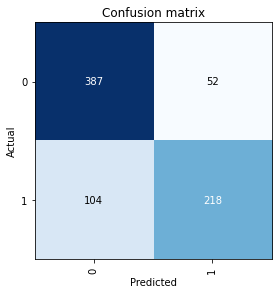

In [24]:
interp.plot_confusion_matrix()

In [25]:
sen = "Well Saturn doesn't exist anymore. So the collision place has a starting estimate of $4000. That's 3 times what my car is worth."
learn.predict(sen)

('1', TensorText(1), TensorText([0.2893, 0.7107]))

## The ULMFiT approach

The Wikipedia English is slightly different from the twitter English. So instead of jumping directly to the classifier, we could fine-tune our pretrained language model to the twitter corpus and then use that as the base for our classifier.

In [26]:
# we use also the test, because we need the text and not the label.
df_test = pd.read_csv(path/'test.csv')
df_all_text = pd.concat([df, df_test], join="inner")
df_all_text

,id,keyword,location,text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/UtbXLcBIuY
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3


In [27]:
def get_X(r): return r['text']
data_block_lm = DataBlock(blocks = (TextBlock.from_df('text', is_lm=True)),
                          get_x=ColReader('text'),
                          splitter=RandomSplitter(0.1)
                          )

dls_lm = data_block_lm.dataloaders(df_all_text)

In [28]:
dls_lm.show_batch(max_n=3)

,text,text_
0,xxbos xxup nws has xxmaj continued a xxmaj severe xxmaj thunderstorm xxmaj warning for oklahoma - ok until 10:30 xxup pm xxbos natural disaster ûò xxmaj news xxmaj stories xxmaj about natural disaster - xxmaj page 1 | xxmaj xxunk http : / / t.co / xxunk xxbos dogs xxmaj lightning reshapes rocks at the atomic level - a lightning strike can xxunk a xxunk 's xxunk structure … http : /,xxup nws has xxmaj continued a xxmaj severe xxmaj thunderstorm xxmaj warning for oklahoma - ok until 10:30 xxup pm xxbos natural disaster ûò xxmaj news xxmaj stories xxmaj about natural disaster - xxmaj page 1 | xxmaj xxunk http : / / t.co / xxunk xxbos dogs xxmaj lightning reshapes rocks at the atomic level - a lightning strike can xxunk a xxunk 's xxunk structure … http : / /
1,t.co / xxunk # course http : / / t.co / xxunk xxbos xxunk ' thanks again for letting me stay here since the xxunk was blown up … .. xxmaj xxunk how are you doing buddy ? ' xxbos xxmaj tomorrow 's evening commute xxunk a xxup red xxup light . a rainstorm xxunk the region will push it 's way in late evening . http : / / t.co /,/ xxunk # course http : / / t.co / xxunk xxbos xxunk ' thanks again for letting me stay here since the xxunk was blown up … .. xxmaj xxunk how are you doing buddy ? ' xxbos xxmaj tomorrow 's evening commute xxunk a xxup red xxup light . a rainstorm xxunk the region will push it 's way in late evening . http : / / t.co / xxunk
2,o xxrep 5 o xxrep 4 h xxrep 3 o h ooh … xxbos * xxunk off of a cliff while drinking tea * \n\n xxmaj this is how xxmaj british people fall off xxunk . xxbos xxmaj nepal earthquake 3 months on : xxmaj women fear abuse https : / / t.co / xxunk via xxunk xxbos # xxunk in 1620 the xxmaj xxunk set sail for the xxmaj new xxmaj,xxrep 5 o xxrep 4 h xxrep 3 o h ooh … xxbos * xxunk off of a cliff while drinking tea * \n\n xxmaj this is how xxmaj british people fall off xxunk . xxbos xxmaj nepal earthquake 3 months on : xxmaj women fear abuse https : / / t.co / xxunk via xxunk xxbos # xxunk in 1620 the xxmaj xxunk set sail for the xxmaj new xxmaj world


Here the task is to guess the next word, so we can see the targets have all shifted one word to the right.

In [29]:
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=accuracy).to_fp16()

In [30]:
learn.fit_one_cycle(1,0.01)

epoch,train_loss,valid_loss,accuracy,time
0,4.574709,3.718764,0.381541,00:27


In [31]:
learn.unfreeze()
learn.fit_one_cycle(5,0.002)

epoch,train_loss,valid_loss,accuracy,time
0,3.796844,3.302622,0.430538,00:34
1,3.505870,3.052238,0.458976,00:33
2,3.214982,2.865276,0.488764,00:33
3,2.986345,2.780571,0.501329,00:33
4,2.830945,2.763354,0.504345,00:33


In [32]:
learn.save('5epoch')

Path('models/5epoch.pth')

In [33]:
learn.fit_one_cycle(5,0.002)

epoch,train_loss,valid_loss,accuracy,time
0,2.762723,2.729435,0.510412,00:34
1,2.716147,2.621895,0.528021,00:33
2,2.557249,2.524371,0.545351,00:33
3,2.389677,2.460129,0.558554,00:33
4,2.262055,2.450491,0.559883,00:33


In [34]:
learn.save_encoder('finetuned')

### Text Generation

In [35]:
TEXT = "That moment when you wish"
N_WORDS = 30
N_SEN = 3
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SEN)]
print("\n".join(preds))

That moment when you wish you were attacked by a person you 'd be it Police : Man Charged with Arson Burglary http : / / t.co /
That moment when you wish you were a sinking walk the way to America ? ? # hot Funtenna : hijacking computers to send data as sound waves [ black Hat
That moment when you wish i could think about it and share it for me If you say that it 's a annihilation # world News August 6 2015


### Text Classifier with ULMFiT approach

In [36]:
def get_X(r): return r['text']
def get_y(r): return r['target']
data_block = DataBlock(blocks=(TextBlock.from_df('text',vocab=dls_lm.vocab),CategoryBlock),
                      get_x=get_X, 
                      get_y=get_y, 
                      splitter=RandomSplitter(0.1))
dls = data_block.dataloaders(df)

In [37]:
dls.show_batch()

,text,category
0,xxbos _ \n▁ xxrep 5 ? xxup retweet \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow xxup all xxup who xxup rt \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup xxunk \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup gain xxup with \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow ? xxunk # xxup xxunk \n▁ # xxup ty,0
1,xxbos xxup info xxup s. xxup wnd : xxunk / 6 . xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup tmp : 10 .,0
2,xxbos xxup info xxup u. xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup tmp : 10 . xxup wnd : xxunk / 6 .,0
3,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,1
4,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,0
5,xxbos xxmaj no # news of # hostages in # xxmaj libya \n\n http : / / t.co / xxunk \n\n▁ # xxmaj india # terrorism # xxmaj africa # xxup ap # xxup ts # xxup nri # xxmaj news # xxup trs # xxup tdp # xxup bjp http : / / t.co / xxunk,1
6,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,0
7,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,1
8,xxbos xxmaj learn xxmaj how i xxmaj gained xxmaj access xxmaj to xxmaj the xxmaj secrets xxmaj of xxmaj the xxmaj top xxmaj earners & & xxmaj used xxmaj them xxmaj to xxmaj explode xxmaj my xxmaj home xxmaj business xxmaj here : http : / / t.co / xxup xxunk xxmaj please # xxup rt,0


In [38]:
learn_classifier = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [39]:
learn_classifier = learn_classifier.load_encoder('finetuned')

In [40]:
learn_classifier.fit_one_cycle(1,0.02)

epoch,train_loss,valid_loss,accuracy,time
0,0.715018,0.435248,0.808147,00:08


In [41]:
learn_classifier.unfreeze()
learn_classifier.fit_one_cycle(3,0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.539206,0.503458,0.754271,00:18
1,0.454128,0.422752,0.831800,00:18
2,0.319473,0.442438,0.834428,00:18


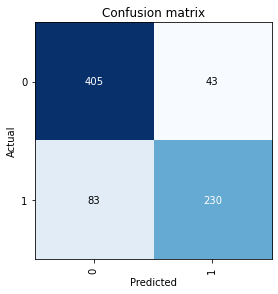

In [42]:
interp = ClassificationInterpretation.from_learner(learn_classifier)
interp.plot_confusion_matrix()

The ULMFiT approach improve the accuracy from 0.795 to 0.834!!